In [1]:
import pandas as pd
import os, sys
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
import torch

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import fcnn_models

## Data

In [3]:
def load_csv_data(file_path: str) -> Tuple[np.ndarray, np.array, np.array]:
    """
    Reads the CSV with all the training data: grayscale log-mel spectrogram pixels, label and author of each sample
    And extracts them respectively, resizing the features to fit the CNN input shape (channel, height, width).

    Args:
        file_path (str): Path to the CSV file containing training data.

    Returns:
        Tuple[np.ndarray, np.array, np.array]: Returns features, labels, and authors from the CSV file. Features shape is (N x 70,112),
        while labels and authors are 1D arrays of size N, where N is the number of samples.
    """
    # Load training data
    df = pd.read_csv(file_path)

    print(f"Dataset shape: {df.shape}")
    print(f"Number of classes: {df['label'].nunique()}")
    print(f"Number of authors: {df['author'].nunique()}")

    # Extract labels, authors, and features
    labels = df['label'].values.astype(np.int64)
    authors = df['author'].values
    features = df.drop(columns=['label', 'author']).values.astype(np.float32)
    print(f"Features shape before reshape: {features.shape} (should be N x 70112!)")

    # Convert to 0-1 range
    features /= 255.0

    print("Features shape:", features.shape)
    print("Labels shape:", labels.shape)
    print("Authors shape:", authors.shape)
    print("Unique classes:", len(np.unique(labels)))
    print("Unique authors:", len(np.unique(authors)))

    # No need for df variable after extracting features, release memory
    del df

    return features, labels, authors

In [4]:
# Keep the old CSV-based loading for compatibility (uncomment if needed)
train_data_path = os.path.join('..', 'database', 'meta', 'final', 'train_data.csv')
features, labels, authors = load_csv_data(train_data_path)

Dataset shape: (2987, 70114)
Number of classes: 33
Number of authors: 106
Features shape before reshape: (2987, 70112) (should be N x 70112!)
Features shape: (2987, 70112)
Labels shape: (2987,)
Authors shape: (2987,)
Unique classes: 33
Unique authors: 106
Features shape before reshape: (2987, 70112) (should be N x 70112!)
Features shape: (2987, 70112)
Labels shape: (2987,)
Authors shape: (2987,)
Unique classes: 33
Unique authors: 106


In [ ]:
# Display class distribution
plt.figure(figsize=(12, 6))
unique_labels, counts = np.unique(labels, return_counts=True)
plt.bar(unique_labels, counts, alpha=0.7)
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Data')
plt.xticks(unique_labels)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average samples per class: {len(labels) / len(unique_labels):.1f}")

In [10]:
# Split with a set seed, las que ya encontre arriba, para tardar menos
from utils.split import get_set_seed_indices, display_split_statistics
seed_single = 245323 # Quality: 0.2671

train_indices, val_indices, best_score, seed = get_set_seed_indices(
    features=features,
    labels=labels, 
    authors=authors,
    test_size=0.2,
    seed=seed_single)

# Extract train and validation data using indices
trFeatures = features[train_indices]
trLabels = labels[train_indices]
trAuthors = authors[train_indices]

vFeatures = features[val_indices]
vLabels = labels[val_indices]
vAuthors = authors[val_indices]

print(f"Training set: {trFeatures.shape[0]} samples")
print(f"Validation set: {vFeatures.shape[0]} samples")
print(f"Split quality score: {best_score}")

display_split_statistics((train_indices, val_indices, best_score, seed), "single")

Training set: 2330 samples
Validation set: 657 samples
Split quality score: 0.26713002574246597

📊 SINGLE SPLIT STATISTICS
----------------------------------------
Random seed: 245323
Train samples: 2330
Validation samples: 657
Split ratio: 78.00% - 22.00%
Quality score: 0.2671
----------------------------------------


In [ ]:
# Convert labels to one-hot encoding for BirdFCNN_v0 model
num_classes = len(np.unique(labels))

def to_one_hot(labels, num_classes):
    """Convert integer labels to one-hot encoding"""
    one_hot = np.zeros((len(labels), num_classes))
    one_hot[np.arange(len(labels)), labels] = 1
    return one_hot

# One-hot encode labels for BirdFCNN_v0 model
trLabels_onehot = to_one_hot(trLabels, num_classes)
vLabels_onehot = to_one_hot(vLabels, num_classes)

print(f"Original labels shape: {trLabels.shape}")
print(f"One-hot labels shape: {trLabels_onehot.shape}")
print(f"Number of classes: {num_classes}")

Original labels shape: (2330,)
One-hot labels shape: (2330, 33)
Number of classes: 33


## Training

In [ ]:
from utils.fcnn_models import BirdFCNN_v0, BirdFCNN

In [ ]:
# Train the hand-implemented BirdFCNN_v0 model
print("="*50)
print("TRAINING NN (HAND-IMPLEMENTED) MODEL")
print("="*50)

# Initialize BirdFCNN_v0 model
nn_model = fcnn_models.BirdFCNN_v0(
    trainX=trFeatures,
    trainY=trLabels_onehot,
    m=[512, 128, 32],  # hidden layers
    seed=42
)

# Train the model (reduced epochs for testing)
nn_model.trainUltimate(
    epochs=50,  # Reduced for fast testing
    lr=0.001,
    batch_size=32,
    optimizer='adam',
    l2_lambda=1e-4,
    valX=vFeatures,
    valy=vLabels_onehot,
    early_stopping=True,
    patience=10,
    eval_interval=1,  # Check every epoch for fast testing
    lr_schedule={'type': 'exponential', 'decay': 0.95}
)

In [ ]:
# Plot training results with accuracy
import matplotlib.pyplot as plt

# Extract the loss history from training
train_losses = BirdFCNN_v0.loss_history if hasattr(BirdFCNN_v0, 'loss_history') else []
val_losses = BirdFCNN_v0.val_loss_history if hasattr(BirdFCNN_v0, 'val_loss_history') else []

if train_losses and val_losses:
    plt.figure(figsize=(12, 4))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # Calculate and plot accuracy
    plt.subplot(1, 2, 2)
    
    # Calculate training accuracy
    train_predictions = nn_model.ff(nn_model.X)[1][-1]  # Get final layer output
    train_pred_classes = np.argmax(train_predictions, axis=1)
    train_true_classes = np.argmax(nn_model.y, axis=1)
    train_accuracy = np.mean(train_pred_classes == train_true_classes)
    
    # Calculate validation accuracy
    val_predictions = nn_model.ff(vFeatures)[1][-1]  # Get final layer output
    val_pred_classes = np.argmax(val_predictions, axis=1)
    val_true_classes = np.argmax(vLabels_onehot, axis=1)
    val_accuracy = np.mean(val_pred_classes == val_true_classes)
    
    print(f"Final Training Accuracy: {train_accuracy:.4f}")
    print(f"Final Validation Accuracy: {val_accuracy:.4f}")
    
    # For plotting accuracy over time, we'd need to store it during training
    # For now, plot final accuracies as bars
    accuracies = [train_accuracy, val_accuracy]
    labels_acc = ['Training', 'Validation']
    
    plt.bar(labels_acc, accuracies, alpha=0.7, color=['blue', 'red'])
    plt.ylabel('Accuracy')
    plt.title('Final Training and Validation Accuracy')
    plt.ylim(0, 1)
    
    # Add accuracy values on top of bars
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Display confusion matrix for BirdFCNN_v0 model
    fcnn_models.plot_confusion_matrix(vLabels_onehot, val_predictions, num_classes=vLabels_onehot.shape[1])
    
else:
    print("No loss history available. Make sure training completed successfully.")

No loss history available. Make sure training completed successfully.


Calculating Nn model performance...
Final Training Accuracy: 0.0391
Final Validation Accuracy: 0.0137


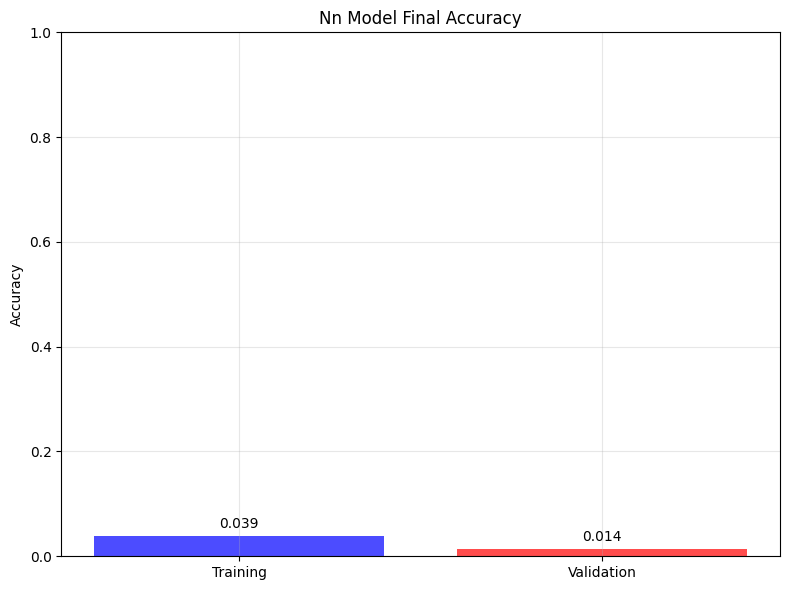

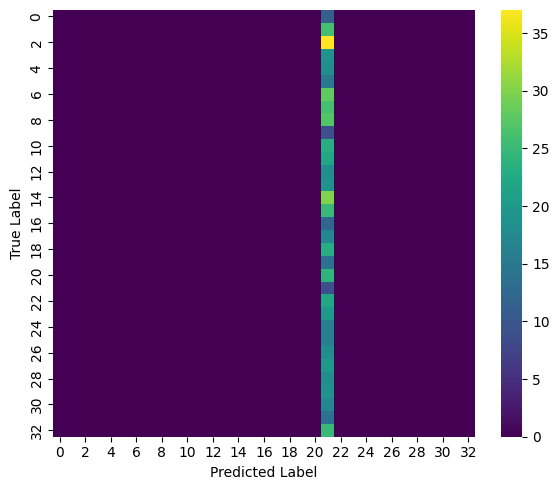

In [ ]:
# Calculate final accuracies for BirdFCNN_v0 model - FIXED VERSION
print("Calculating BirdFCNN_v0 model performance...")

# Calculate training accuracy
train_predictions = nn_model.ff(nn_model.X)[1][-1]  # Get final layer output
train_pred_classes = np.argmax(train_predictions, axis=1)
train_true_classes = np.argmax(nn_model.y, axis=1)
train_accuracy = np.mean(train_pred_classes == train_true_classes)

# Calculate validation accuracy
val_predictions = nn_model.ff(vFeatures)[1][-1]  # Get final layer output
val_pred_classes = np.argmax(val_predictions, axis=1)
val_true_classes = np.argmax(vLabels_onehot, axis=1)
val_accuracy = np.mean(val_pred_classes == val_true_classes)

print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

# Plot final accuracies
plt.figure(figsize=(8, 6))
accuracies = [train_accuracy, val_accuracy]
labels_acc = ['Training', 'Validation']

plt.bar(labels_acc, accuracies, alpha=0.7, color=['blue', 'red'])
plt.ylabel('Accuracy')
plt.title('BirdFCNN_v0 Model Final Accuracy')
plt.ylim(0, 1)

# Add accuracy values on top of bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display confusion matrix
fcnn_models.plot_confusion_matrix(vLabels_onehot, val_predictions, num_classes=vLabels_onehot.shape[1])

In [ ]:
# Save the BirdFCNN_v0 model
import os
os.makedirs('../models', exist_ok=True)
nn_model.save_model('../models/nn_model.npy')
print("BirdFCNN_v0 model saved successfully!")

Nn model saved to ../models/nn_model.npy
Nn model saved successfully!


In [ ]:
# Print detailed results summary for BirdFCNN_v0 model
print("="*50)
print("NN (HAND-IMPLEMENTED) TRAINING RESULTS SUMMARY")
print("="*50)

print(f"\nModel Architecture:")
print(f"Hidden layers: [512, 128, 32]")
print(f"Total parameters: {sum([np.prod(w.shape) for w in nn_model.W[1:] if w is not None])}")

print(f"\nFinal Performance:")
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

if hasattr(nn_model, 'loss_history') and nn_model.loss_history:
    final_train_loss = nn_model.loss_history[-1]
    final_val_loss = nn_model.val_loss_history[-1] if nn_model.val_loss_history else "N/A"
    print(f"Final Training Loss: {final_train_loss:.4f}")
    print(f"Final Validation Loss: {final_val_loss}")

print("\n" + "="*50)

NN (HAND-IMPLEMENTED) TRAINING RESULTS SUMMARY

Model Architecture:
Hidden layers: [512, 128, 32]
Total parameters: 35968032

Final Performance:
Training Accuracy: 0.0391 (3.91%)
Validation Accuracy: 0.0137 (1.37%)
Final Training Loss: 3.4901
Final Validation Loss: 3.4976377639316203



Abajo, probar BirdFCNN

Epoch 1/3 - Train Loss: 3.3612 - Acc: 0.0824 - Val Loss: 3.5024 - Val Acc: 0.0107
Epoch 2/3 - Train Loss: 3.2949 - Acc: 0.1116 - Val Loss: 3.5117 - Val Acc: 0.0152
Epoch 2/3 - Train Loss: 3.2949 - Acc: 0.1116 - Val Loss: 3.5117 - Val Acc: 0.0152
Epoch 3/3 - Train Loss: 3.2381 - Acc: 0.1391 - Val Loss: 3.5237 - Val Acc: 0.0228
Epoch 3/3 - Train Loss: 3.2381 - Acc: 0.1391 - Val Loss: 3.5237 - Val Acc: 0.0228


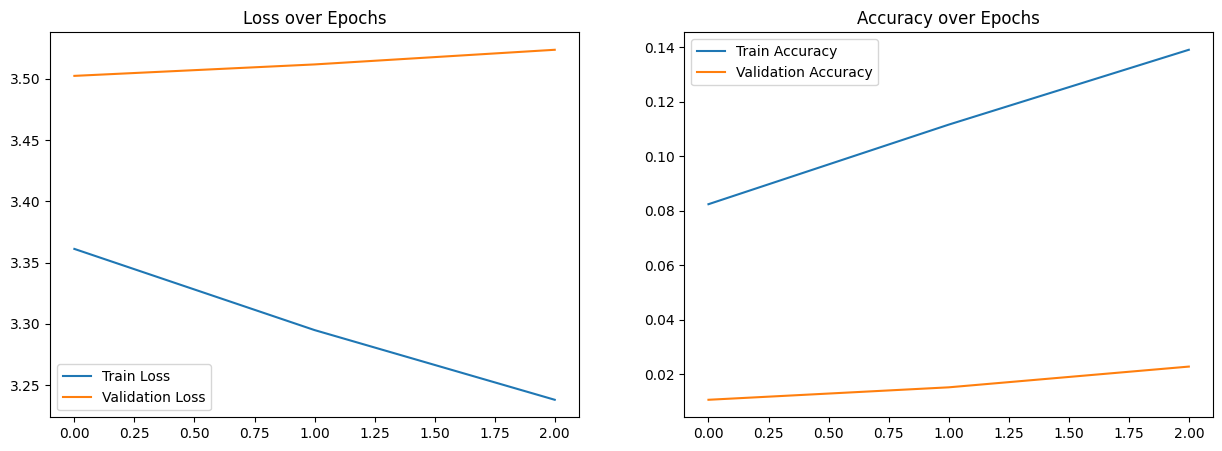

Model saved to ../models/birdfcnn_model.pth
BirdFCNN model saved successfully!
BIRDFCNN (PYTORCH) TRAINING RESULTS SUMMARY
Model saved to: ../models/birdfcnn_model.pth


In [ ]:
fcnn = fcnn_models.BirdFCNN(num_classes=num_classes,
                        input_dim=trFeatures.shape[1],
                        hidden_layers=[512, 128, 32])

# Convert one-hot back to class indices for PyTorch model
trainY_indices = trLabels  # already in index form
valY_indices = vLabels     # already in index form

fcnn.train_model(trFeatures, trainY_indices, valX=vFeatures, valY=valY_indices, 
                epochs=50, lr=0.001, batch_size=32, optimizer_type='adam',  # Reduced epochs for fast testing
                device='cuda' if torch.cuda.is_available() else 'cpu', class_weights=None,
                eval_interval=1)  # Check every epoch for fast testing

# Save the BirdFCNN model
fcnn.save_model('../models/birdfcnn_model.pth')
print("BirdFCNN model saved successfully!")

# Print BirdFCNN summary
print("="*50)
print("BIRDFCNN (PYTORCH) TRAINING RESULTS SUMMARY")
print("="*50)
print(f"Model saved to: ../models/birdfcnn_model.pth")
print("="*50)



In [ ]:
# Final Model Comparison Summary
print("="*60)
print("FINAL MODEL COMPARISON SUMMARY")
print("="*60)

print(f"\n🔬 DATASET INFORMATION:")
print(f"   Total samples: {features.shape[0]}")
print(f"   Features dimension: {features.shape[1]}")
print(f"   Number of classes: {num_classes}")
print(f"   Training samples: {trFeatures.shape[0]}")
print(f"   Validation samples: {vFeatures.shape[0]}")

print(f"\n🧠 MODEL ARCHITECTURES:")
print(f"   Both models use: [512, 128, 32] hidden layers")
print(f"   Input dimension: {trFeatures.shape[1]}")
print(f"   Output classes: {num_classes}")

print(f"\n📊 PERFORMANCE COMPARISON:")
print(f"   BirdFCNN_v0 (Hand-implemented):")
print(f"      - Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"      - Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

# Calculate final accuracy for BirdFCNN
device = 'cuda' if torch.cuda.is_available() else 'cpu'
fcnn.eval()
with torch.no_grad():
    # Training accuracy
    train_tensor = torch.tensor(trFeatures, dtype=torch.float32, device=device)
    train_outputs = fcnn(train_tensor)
    train_preds = torch.argmax(train_outputs, dim=1).cpu().numpy()
    fcnn_train_acc = np.mean(train_preds == trainY_indices)
    
    # Validation accuracy
    val_tensor = torch.tensor(vFeatures, dtype=torch.float32, device=device)
    val_outputs = fcnn(val_tensor)
    val_preds = torch.argmax(val_outputs, dim=1).cpu().numpy()
    fcnn_val_acc = np.mean(val_preds == valY_indices)

print(f"   BirdFCNN (PyTorch):")
print(f"      - Training Accuracy: {fcnn_train_acc:.4f} ({fcnn_train_acc*100:.2f}%)")
print(f"      - Validation Accuracy: {fcnn_val_acc:.4f} ({fcnn_val_acc*100:.2f}%)")

print(f"\n💾 SAVED MODELS:")
print(f"   - BirdFCNN_v0 model: ../models/nn_model.npy")
print(f"   - BirdFCNN model: ../models/birdfcnn_model.pth")

print(f"\n🏆 BEST MODEL:")
if val_accuracy > fcnn_val_acc:
    print(f"   Hand-implemented BirdFCNN_v0 model performs better!")
elif fcnn_val_acc > val_accuracy:
    print(f"   PyTorch BirdFCNN model performs better!")
else:
    print(f"   Both models perform equally well!")

print("="*60)

FINAL MODEL COMPARISON SUMMARY

🔬 DATASET INFORMATION:
   Total samples: 2987
   Features dimension: 70112
   Number of classes: 33
   Training samples: 2330
   Validation samples: 657

🧠 MODEL ARCHITECTURES:
   Both models use: [512, 128, 32] hidden layers
   Input dimension: 70112
   Output classes: 33

📊 PERFORMANCE COMPARISON:
   Nn (Hand-implemented):
      - Training Accuracy: 0.0391 (3.91%)
      - Validation Accuracy: 0.0137 (1.37%)
   BirdFCNN (PyTorch):
      - Training Accuracy: 0.1391 (13.91%)
      - Validation Accuracy: 0.0228 (2.28%)

💾 SAVED MODELS:
   - Nn model: ../models/nn_model.npy
   - BirdFCNN model: ../models/birdfcnn_model.pth

🏆 BEST MODEL:
   PyTorch BirdFCNN model performs better!
